<a href="https://colab.research.google.com/github/asya474/car_classigication_neural_networks/blob/main/car_classification_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug 10 13:40:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
!pip install tensorflow_addons -q
import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers.schedules import *
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("/content/drive/MyDrive/Colab Notebooks/input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

     |████████████████████████████████| 1.1 MB 4.7 MB/s 
Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.8.2
Keras        : 2.8.0


In [3]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
RANDOM_SEED=42
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# для Google Colab:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip
sample_submission_path = '/content/sf-dl-car-classification/sample-submission.csv'
train_path = '/content/train/'
sub_path = '/content/test_upload/'

#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
/ [1 files][  1.6 GiB/  1.6 GiB]   65.7 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


In [4]:
train_df = pd.read_csv('sf-dl-car-classification/train.csv')
sample_submission = pd.read_csv('sf-dl-car-classification/sample-submission.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [5]:
train_df['Category'].value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5])

train_generator = train_datagen.flow_from_directory(
    './train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data
  

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = train_datagen.flow_from_directory(
    './train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [7]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83697664/83683744 [==============================] - 1s 0us/step


In [8]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [9]:
base_model.trainable=False

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
print(len(model.layers))

135


In [12]:
print(len(model.trainable_variables))

2


In [13]:
#Step 1
LR=1e-4
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

# Новый раздел

In [14]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=4, verbose=0, mode="max", min_lr=0.00001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [15]:
history = model.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator, 
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = 40,
                    callbacks = callbacks_list
                    )

Epoch 1/40
206/206 [==============================] - ETA: 0s - loss: 2.2248 - accuracy: 0.1798
Epoch 1: val_accuracy improved from -inf to 0.31684, saving model to best_model.hdf5
206/206 [==============================] - 296s 1s/step - loss: 2.2248 - accuracy: 0.1798 - val_loss: 1.9948 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 2/40
206/206 [==============================] - ETA: 0s - loss: 1.9785 - accuracy: 0.2823
Epoch 2: val_accuracy improved from 0.31684 to 0.36285, saving model to best_model.hdf5
206/206 [==============================] - 264s 1s/step - loss: 1.9785 - accuracy: 0.2823 - val_loss: 1.8490 - val_accuracy: 0.3628 - lr: 1.0000e-04
Epoch 3/40
206/206 [==============================] - ETA: 0s - loss: 1.8620 - accuracy: 0.3288
Epoch 3: val_accuracy improved from 0.36285 to 0.38802, saving model to best_model.hdf5
206/206 [==============================] - 265s 1s/step - loss: 1.8620 - accuracy: 0.3288 - val_loss: 1.7620 - val_accuracy: 0.3880 - lr: 1.0000e-04
Epoc

In [16]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [17]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 40s 1s/step - loss: 1.2995 - accuracy: 0.5547
Accuracy: 55.47%


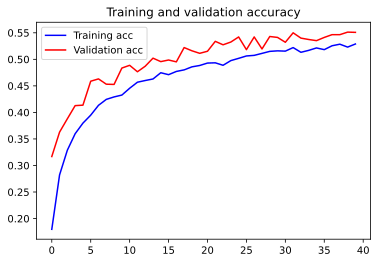

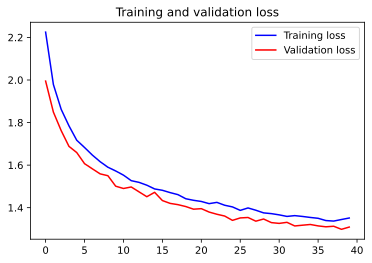

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [19]:
#Step 2
base_model.trainable = True

In [20]:
LR=1e-4
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [21]:
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/15
206/206 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.7920
Epoch 1: val_accuracy improved from 0.55122 to 0.75955, saving model to best_model.hdf5
206/206 [==============================] - 359s 2s/step - loss: 0.5796 - accuracy: 0.7920 - val_loss: 0.7697 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 2/15
206/206 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8925
Epoch 2: val_accuracy improved from 0.75955 to 0.79774, saving model to best_model.hdf5
206/206 [==============================] - 344s 2s/step - loss: 0.2987 - accuracy: 0.8925 - val_loss: 0.6534 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 3/15
206/206 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9152
Epoch 3: val_accuracy did not improve from 0.79774
206/206 [==============================] - 342s 2s/step - loss: 0.2325 - accuracy: 0.9152 - val_loss: 0.8230 - val_accuracy: 0.7691 - lr: 0.0010
Epoch 4/15
206/206 [==============================

In [22]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [23]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 39s 1s/step - loss: 0.2113 - accuracy: 0.9253
Accuracy: 92.53%


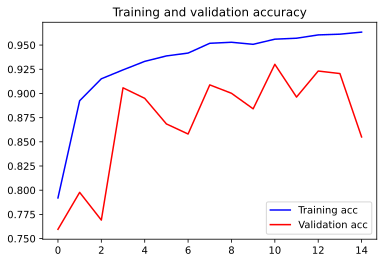

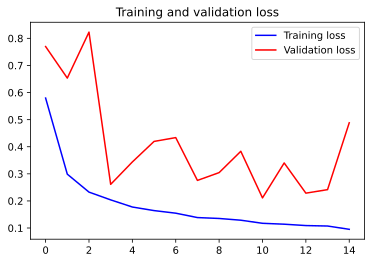

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [25]:
#TTA

In [26]:
model.load_weights('best_model.hdf5')

In [27]:
test_sub_datagen = ImageDataGenerator(#rescale=1. / 255,
                                  rotation_range = 15,
                                  shear_range=0.2,
                                  zoom_range=[0.75,1.25],
                                  brightness_range=[0.5, 1.5],
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,)

In [28]:
test_sub_generator = test_sub_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


# Новый раздел

In [29]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

105/105 [==============================] - 110s 1s/step


In [30]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [31]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [32]:
submission.value_counts()

Id          Category
293307.jpg  5           1
70859.jpg   5           1
71936.jpg   5           1
71927.jpg   5           1
71921.jpg   5           1
                       ..
43674.jpg   5           1
43670.jpg   5           1
43641.jpg   5           1
43638.jpg   5           1
99984.jpg   5           1
Length: 6675, dtype: int64

In [33]:
submission.head()

,Id,Category
0,305108.jpg,5
1,295075.jpg,5
2,31197.jpg,5
3,93598.jpg,5
4,87877.jpg,5
